<h2 align="center">Predicting Bike Sharing Demand 
    <h2 align="center">with Supervised Machine Learning, by Linear Regression (Regression)
</h2>

__1) The Goal:__ Build and train a regression model on the Capital Bike Share (Washington, D.C.) Kaggle data set to predict the total count of bikes rented during each hour covered by the test set, using only the information (time- and weather-related features) available prior to the rental period.   

A practical application of such a project would help you answer the following question, as an example: “Given the forecasted weather conditions, how many bicycles can we expect to be rented out (city-wide) this Saturday at 2pm?”

__2) Get the Data:__ You are provided hourly rental data spanning two years. Download the [Capital Bike Share Dataset](https://www.kaggle.com/c/bike-sharing-demand/data) from Kaggle and explore the data in pandas.   

__3) Split the Data:__ Already split: "train.csv" and "test.csv". The training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. 

__4) Exploratory Data Analysis (EDA)__

__5)-9) Feature Engineering (FE), Train Model, Optimize Hyperparameters/Cross-Validation:__ Optimize the model iteratively, select features, try different regressors (e.g. Linear Regression, Random Forest Regressor, SVR)

__10) Calculate Test Score:__ Because this is a regression problem, we are not evaluating our models using accuracy! Submissions are evaluated on the Root Mean Squared Logarithmic Error RMSLE. The RMSLE is calculated as

\begin{equation} \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 } \end{equation}
Benchmarks:
- RMSLE < 0.5, is excellent! ⭐⭐⭐ 
- RMSLE < 0.75 is also quite solid ⭐⭐ 
- RMSLE > 1.0 means that there is still some FE work to do.  

__11) Deploy and Monitor:__ Submit your prediction to Kaggle.  

---

<h2 align="center"><strong>Exploratory Data Analysis</strong></h2>

In [5]:
import pandas as pd

data = pd.read_csv('./raw data/train.csv', index_col='datetime', parse_dates=True)
data.head(1)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01,1,0,0,1,9.84,14.395,81,0.0,3,13,16


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  count       10886 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 1020.6 KB


The data fields are:  
__datetime:__ hourly date + timestamp  
__season__: 1. spring,  
&emsp;&emsp;&emsp;&emsp;2. summer,  
&emsp;&emsp;&emsp;&emsp;3. fall,  
&emsp;&emsp;&emsp;&emsp;4. winter  
__holiday:__ whether the day is considered a holiday  
__workingday:__ whether the day is neither a weekend nor holiday  
__weather__:&emsp;1. Clear, Few clouds, Partly cloudy, Partly cloudy  
&emsp;&emsp;&emsp;&emsp;&emsp;2. Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist  
&emsp;&emsp;&emsp;&emsp;&emsp;3. Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds  
&emsp;&emsp;&emsp;&emsp;&emsp;4. Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
__temp:__ temperature in Celsius  
__atemp:__ "feels like" temperature in Celsius  
__humidity:__ relative humidity  
__windspeed:__ wind speed  
__casual:__ number of non-registered user rentals initiated  
__registered:__ number of registered user rentals initiated   
__count:__ number of total rentals

__Questions for EDA:__
- Which factors contribute most to the number of bicycles being checked out over the course of a given day?
- How much of an impact does weather have on demand?
- How does the behavior of casual users differ from subscribers?

The value in the __count__ column is the one you need to predict. Beware that combining the columns __casual__ and __registered__ results in the column __count__. Therefore you should exclude those columns from your model!

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='white')

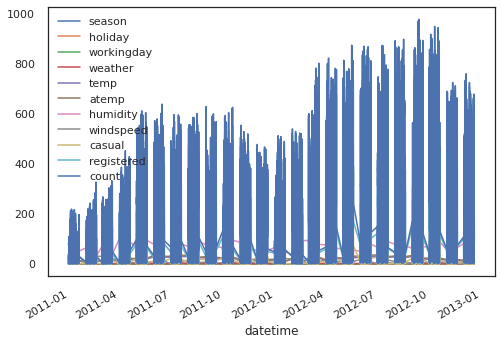

In [63]:
data.plot(); # too many data points -> resample, see below

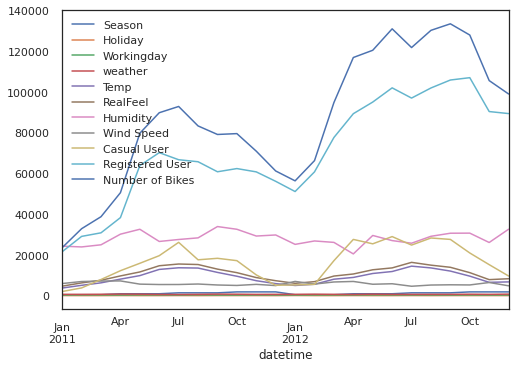

In [55]:
data.columns = ['Season', 'Holiday', 'Workingday', 'weather', 'Temp', 'RealFeel', 'Humidity', 'Wind Speed', 'Casual User', 'Registered User', 'Number of Bikes']
data.resample('M').sum().plot(); 

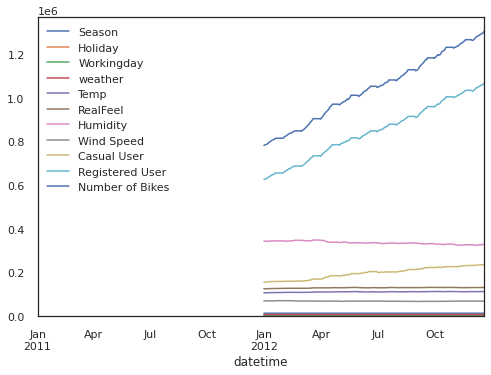

In [56]:
#data_count = pd.DataFrame(data['count'])
ax = data.resample('D').sum().rolling(365).sum().plot(); 
ax.set_ylim(0, None);

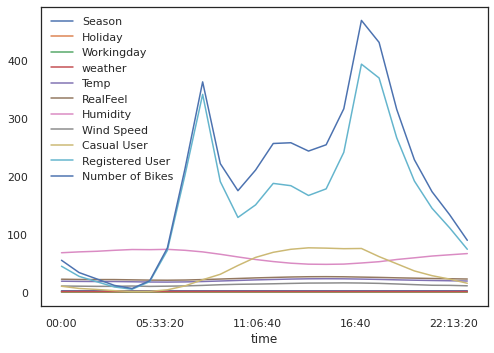

In [57]:
data.groupby(data.index.time).mean().plot();

In [13]:
pivoted = data.pivot_table('count', index=data.index.time, columns=data.index.date)
#pivoted.iloc[:5, :5]
pivoted.head()

,2011-01-01,2011-01-02,2011-01-03,2011-01-04,2011-01-05,2011-01-06,2011-01-07,2011-01-08,2011-01-09,2011-01-10,...,2012-12-10,2012-12-11,2012-12-12,2012-12-13,2012-12-14,2012-12-15,2012-12-16,2012-12-17,2012-12-18,2012-12-19
00:00:00,16.0,17.0,5.0,5.0,6.0,11.0,17.0,25.0,25.0,5.0,...,20.0,31.0,34.0,32.0,47.0,94.0,110.0,28.0,18.0,41.0
01:00:00,40.0,17.0,2.0,2.0,6.0,4.0,7.0,16.0,12.0,1.0,...,4.0,8.0,21.0,23.0,26.0,95.0,96.0,15.0,15.0,15.0
02:00:00,32.0,9.0,NaN,1.0,2.0,2.0,1.0,16.0,11.0,3.0,...,5.0,1.0,9.0,8.0,9.0,69.0,87.0,5.0,7.0,3.0
03:00:00,13.0,6.0,NaN,NaN,NaN,NaN,NaN,7.0,4.0,1.0,...,4.0,3.0,10.0,2.0,12.0,23.0,38.0,3.0,5.0,5.0
04:00:00,1.0,3.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,3.0,...,12.0,8.0,4.0,8.0,10.0,6.0,11.0,5.0,8.0,7.0


For FE pipeline:

logarithm on the target column
interactions between the weekday and the hours because the hours in the weekend mean something else

or use a model that does it auto like a random forest regressor 

In [11]:
now = pd.to_datetime('today')
now.tz_localize('UTC').tz_convert('Europe/Berlin')
#timezone conversion can be useful as well, though we don't need this this week.

Timestamp('2021-01-27 11:48:50.257305+0100', tz='Europe/Berlin')

In [ ]:
cmap = sns.diverging_palette(239, 239, s=100, as_cmap=True) 
sns.heatmap(xtrain.corr(), annot=True, center=0, cmap = cmap) 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

#### Step 1: Read the file train.csv into Python and print a few rows.

In [81]:
train = pd.read_csv('./raw data/train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### Step 2: Calculate the number of surviving/non-surviving passengers and display it as a bar plot.

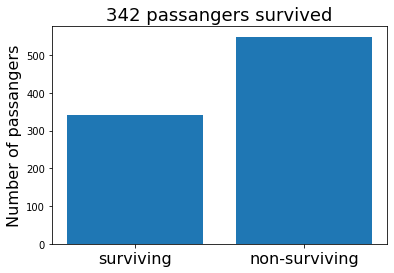

In [3]:
i=sum(train['Survived'])

labels_step2 = ['surviving', 'non-surviving']
x = np.arange(len(labels_step2))
y = [sum(train['Survived']), (train['Survived'].count()-sum(train['Survived']))]
 
plt.bar(x, y)
plt.xticks(x, labels_step2, size=16)

plt.title('%i passangers survived' %i, fontsize=18)
plt.ylabel('Number of passangers', fontsize=16)
plt.show()

#### Step 3: Calculate the proportion of surviving 1st class passengers with regards to the total number of 1st class passengers.

In [4]:
print('{}% of the 1st class passengers survived.'.format(100*round(train[(train['Pclass']==1) & (train['Survived']==1)]['Survived'].count()/sum(train['Pclass']==1),2)))

63.0% of the 1st class passengers survived.


#### Step 4: Create a bar plot with separate bars for male/female passengers and 1st/2nd/3rd class passengers.

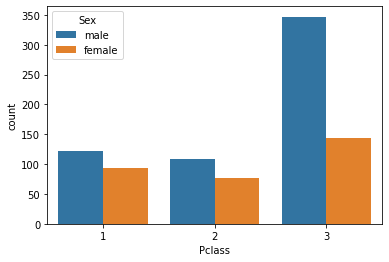

In [11]:
ax = sns.countplot(x="Pclass", hue="Sex", data=train)

#### Step 5: Create a histogram showing the age distribution of passengers. Compare surviving/non-surviving passengers.

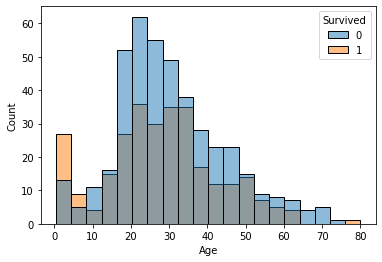

In [19]:
ax = sns.histplot(x="Age", hue="Survived", data=train)

#### Step 6: Calculate the average age for survived and drowned passengers separately.

In [36]:
print('The average age of the survived passengers is {}, and the average age of the drowned passengers is {}.'.format(round(train.groupby('Survived')['Age'].mean().tolist()[0]),round(train.groupby('Survived')['Age'].mean().tolist()[1])))

The average age of the survived passengers is 31, and the average age of the drowned passengers is 28.


#### Step 7: Replace missing age values by the mean age.

In [69]:
train['Age_mean_imputed'] = train['Age'].fillna(round(np.float64(train['Age'].mean()),1))

#### Step 8: Create a table counting the number of surviving/dead passengers separately for 1st/2nd/3rd class and male/female.

In [80]:
pd.crosstab(train['Pclass'], [train['Sex'], train['Survived']], rownames=['Pclass'], colnames=['Sex', 'Survived'])

Sex      female     male    
Survived      0   1    0   1
Pclass                      
1             3  91   77  45
2             6  70   91  17
3            72  72  300  47

<h2> <center>Feature Engineering</h2> </center>

In [ ]:
train.fillna(0.0, inplace=True) # little crutch to make the data work

<h2> <center>Train the Model</h2> </center>

<h2> <center>Optimize Hyperparameters/Cross-Validation</h2> </center>

Train Model, Optimize Hyperparameters/Cross-Validation

- Train a Logistic Regression classification model (alternative models: Decision Trees, Random Forest)
- Create features using one-hot encoding
- Calculate the train and test accuracy
- Calculate a cross-validation score
- Train a Random Forest classification model
- Submit the predictions to Kaggle
- Give a 5-minute lightning talk by the end of the week

#### 10) Calculate Test Score
- Use the test data set aside to calculate the test score.

#### 11) Deploy and Monitor

<h2> <center>Calculate Test Score</h2> </center>



<h2> <center>Evaluate the Model using the Test Data</h2> </center>

- accuracy
- confussion matrix: precission, recall, F1-score

<h2> <center>Make Predictions</h2> </center>